In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler, QuantileTransformer, PowerTransformer, OneHotEncoder, OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer

# Načítanie dát

V predchádzajúcej fáze sme zistili, že dôležité dáta sú len v tabuľkách connections a processes. Nedáva teda zmysel znova pracovať so všetkými dátami. Načítame teda len connections and processes a vytvoríme pre ne novú pipeline.

In [613]:
connections = pd.read_csv('data/081/connections.csv', on_bad_lines='warn', delimiter='\t')
processes = pd.read_csv('data/081/processes.csv', on_bad_lines='warn', delimiter='\t')

In [614]:
data = pd.merge(connections, processes, on=['mwra', 'imei', 'ts'])

In [615]:
data = data.drop(columns=['ts', 'imei'])

In [616]:
X = data.drop(columns='mwra')
y = data['mwra']

Teraz si vytvoríme pipeline na predspracovanie naších dát.

Definujeme, si ktoré stĺpce pripomínajú normálnu distribúciu.

In [617]:
normal = ['c.android.youtube', 'c.android.chrome', 'c.android.gm', 'c.dogalize', 'c.katana', 'c.UCMobile.x86', 
          'c.updateassist', 'p.android.packageinstaller', 'p.android.documentsui', 'p.system', 'p.android.externalstorage', 
          'p.android.chrome', 'p.android.settings', 'p.android.gm', 'p.inputmethod.latin', 'p.process.gapps', 'p.notifier',]

non_normal = ['c.android.vending', 'c.UCMobile.intl', 'c.raider', 'p.android.vending', 'p.katana', 'p.google', 
              'p.android.defcontainer', 'p.simulator', 'p.android.gms', 'p.dogalize', 
              'p.gms.persistent', 'p.browser.provider', 'p.olauncher']


In [618]:
def delete_outliers(X):
    # Check if X is a DataFrame; if not, convert it temporarily
    if isinstance(X, pd.DataFrame):
        X_copy = X.copy()
    else:
        X_copy = pd.DataFrame(X)

    for col in X_copy.columns:
        Q3 = X_copy[col].quantile(0.75)
        Q1 = X_copy[col].quantile(0.25)
        IQR = Q3 - Q1
        # Identify rows that are outliers
        outlier_indexes = X_copy[(X_copy[col] < Q1 - 1.5 * IQR) | (X_copy[col] > Q3 + 1.5 * IQR)].index
        # Drop outliers
        X_copy.drop(outlier_indexes, inplace=True)

    # Return the processed DataFrame or array
    return X_copy.to_numpy() if not isinstance(X, pd.DataFrame) else X_copy

In [619]:
outlier_remover = FunctionTransformer(delete_outliers)

normal_preprocessor = Pipeline(steps=[
    ("power_transformer", PowerTransformer(method='yeo-johnson', standardize=True)),
    ("scaler", StandardScaler())]
)
non_normal_preprocessor = Pipeline(steps=[
    ("quantile", QuantileTransformer(output_distribution='normal', random_state=0, n_quantiles=1000)    ),
    ("scaler", StandardScaler())]
)
"""

normal_transformer = make_column_transformer(
    (PowerTransformer(method='yeo-johnson', standardize=True), columns_name_to_index(normal, data)),
    remainder='passthrough'
)

non_normal_transformer = make_column_transformer(
    (QuantileTransformer(output_distribution='normal', random_state=0, n_quantiles=1000), columns_name_to_index(non_normal, data)),
    remainder='passthrough'
)"""

"\n\nnormal_transformer = make_column_transformer(\n    (PowerTransformer(method='yeo-johnson', standardize=True), columns_name_to_index(normal, data)),\n    remainder='passthrough'\n)\n\nnon_normal_transformer = make_column_transformer(\n    (QuantileTransformer(output_distribution='normal', random_state=0, n_quantiles=1000), columns_name_to_index(non_normal, data)),\n    remainder='passthrough'\n)"

In [620]:
"""preprocessing_pipeline = Pipeline(steps=[
    ("outlier_removal", outlier_remover),
    ("non_normal_transformer", non_normal_transformer),
    ("normal_transformer", normal_transformer), 
    ('dataframe' ,FunctionTransformer(lambda x: pd.DataFrame(x, columns = data.columns)))], verbose=True)"""

preprocessor = ColumnTransformer(
    transformers=[
        ("normal", normal_preprocessor, normal),
        ("non_normal", non_normal_preprocessor, non_normal)
    ]
)

pipeline = Pipeline(steps=[
    ('outlier_removal', FunctionTransformer(delete_outliers)),
    ('preprocessor', preprocessor),
])
X_transformed = pipeline.fit_transform(X)
X = pd.DataFrame(X_transformed, columns=normal + non_normal)

C:\Users\nayhu\AppData\Local\Temp\ipykernel_29192\3417345457.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  X.hist(ax=ax)


array([[<Axes: title={'center': 'c.android.youtube'}>,
        <Axes: title={'center': 'c.android.chrome'}>,
        <Axes: title={'center': 'c.android.gm'}>,
        <Axes: title={'center': 'c.dogalize'}>,
        <Axes: title={'center': 'c.katana'}>],
       [<Axes: title={'center': 'c.UCMobile.x86'}>,
        <Axes: title={'center': 'c.updateassist'}>,
        <Axes: title={'center': 'p.android.packageinstaller'}>,
        <Axes: title={'center': 'p.android.documentsui'}>,
        <Axes: title={'center': 'p.system'}>],
       [<Axes: title={'center': 'p.android.externalstorage'}>,
        <Axes: title={'center': 'p.android.chrome'}>,
        <Axes: title={'center': 'p.android.settings'}>,
        <Axes: title={'center': 'p.android.gm'}>,
        <Axes: title={'center': 'p.inputmethod.latin'}>],
       [<Axes: title={'center': 'p.process.gapps'}>,
        <Axes: title={'center': 'p.notifier'}>,
        <Axes: title={'center': 'c.android.vending'}>,
        <Axes: title={'center': 'c.

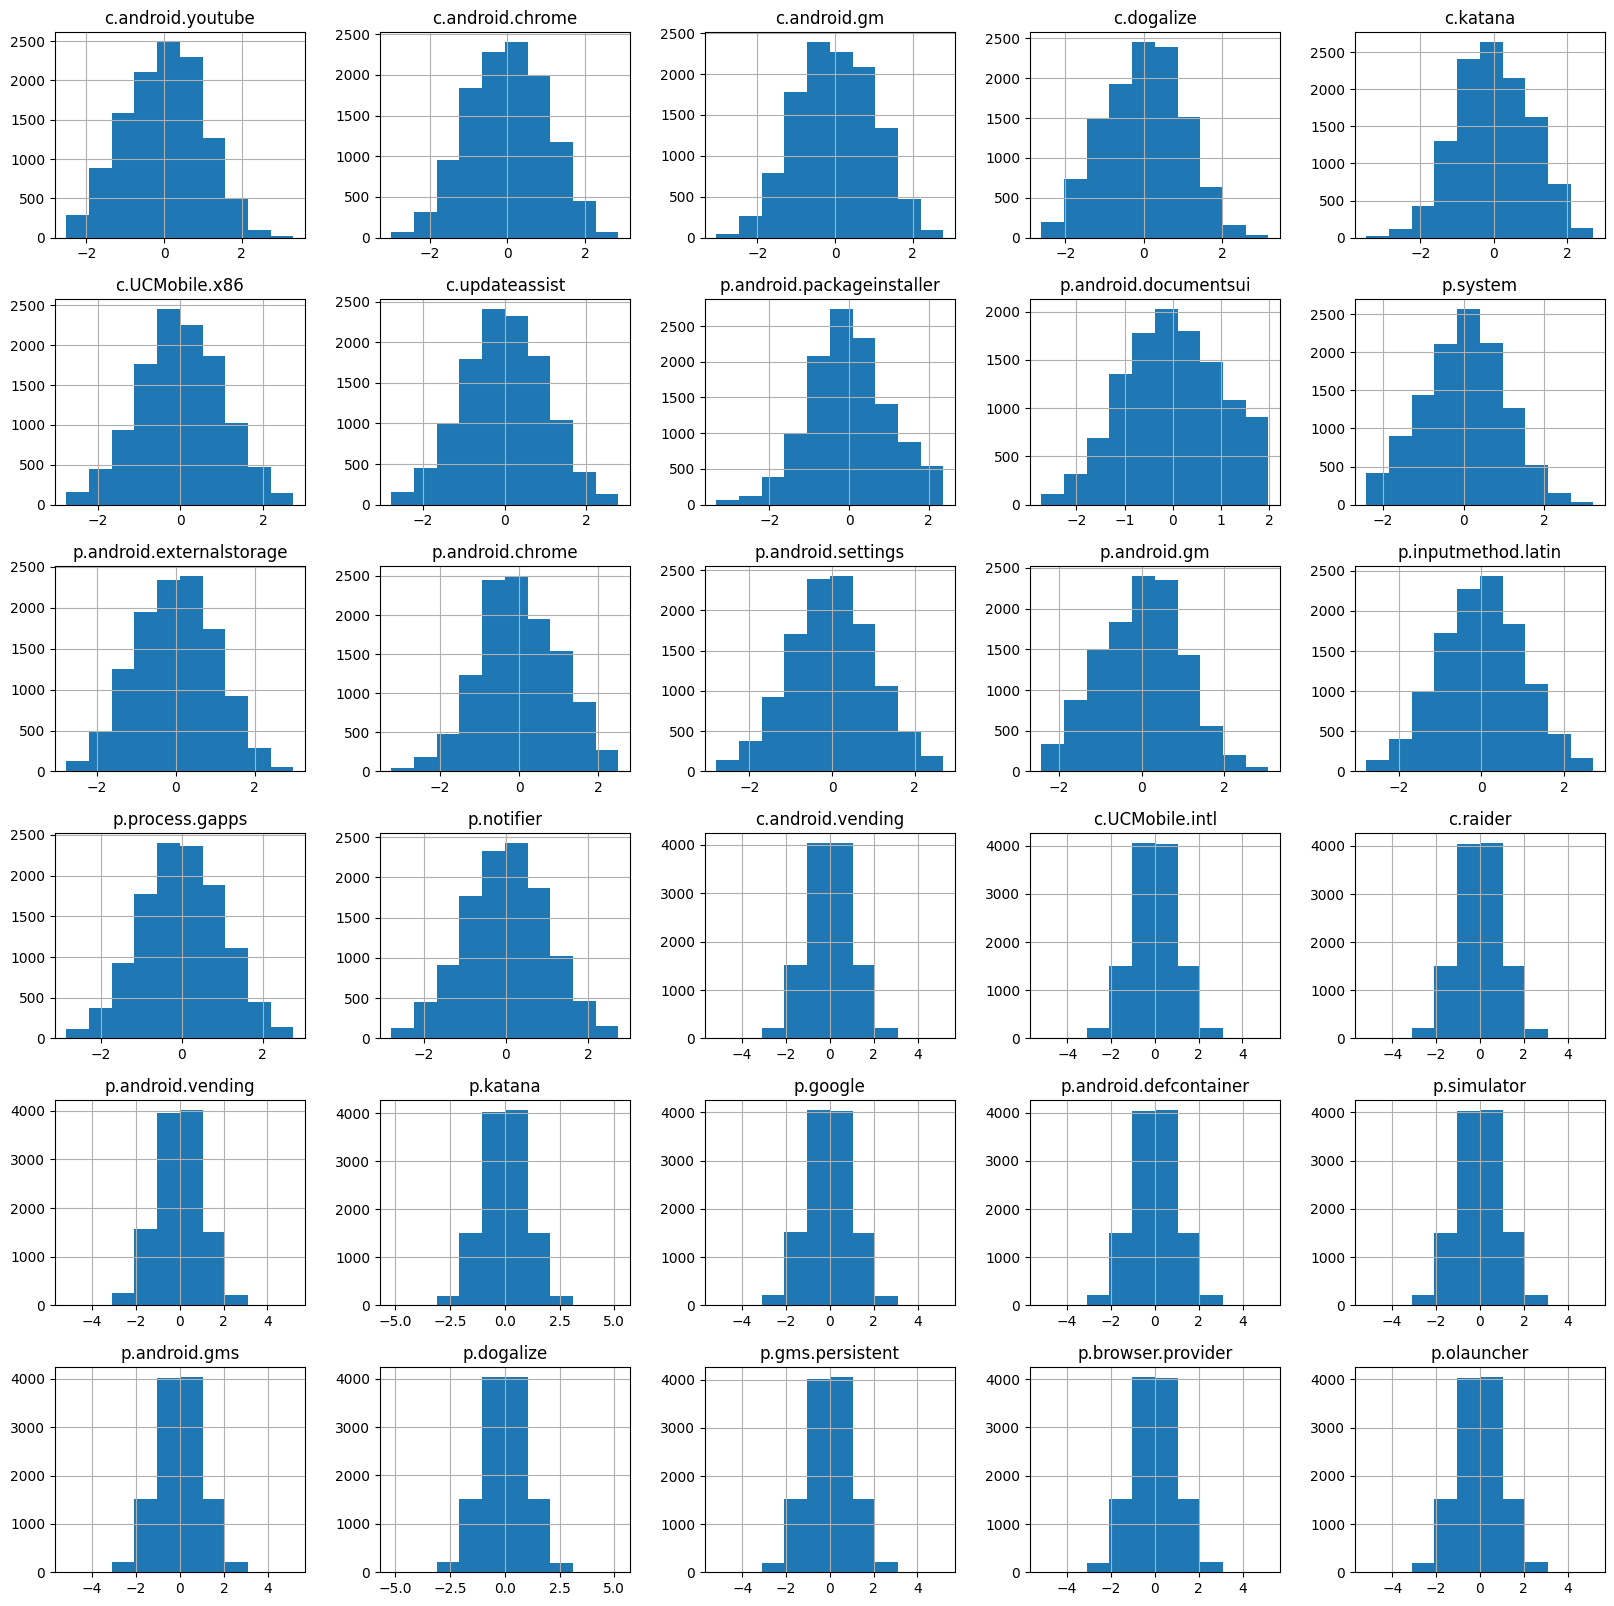

In [621]:


fig = plt.figure(figsize = (20,20))
ax = fig.gca()
X.hist(ax=ax)

# 3.1

## 3.1 A
V tejto časti naiplmenetujem jednoduchý id3 klasifikátor. 